# Identifying matches in pairs of validated floe images

In most cases, the Aqua and Terra images are close enough together in time that the floes are in essentially the same position. 

# Things to note
- For the manual matching: if drift appears small, unambiguous matches can be retrieved even with no optical flow skill
- Optical flow mainly works if the clouds are thin or absent; for thin clouds, best if cloud cover similar throughout image
- Chance to improve floe labels as well -- many are not as good as I'd like
- Some seem to have wrong name, even!
- Mark down ones that are not expected to work well at all, only attempt the "good" ones

In [2]:
import skimage as sk
import proplot as pplt
import numpy as np
import os
import pandas as pd

from skimage.color import rgba2rgb

/opt/homebrew/Caskroom/miniconda/base/envs/eval_seg/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
modis_loc = "../data/modis/truecolor/"
labeled_loc = "../data/validation_images/labeled_floes/"
labeled_images = [f for f in os.listdir(labeled_loc) if "tiff" in f]

In [19]:
# check that both cases are there 
aqua_cases = list(filter(lambda x: 'aqua' in x, labeled_images))
cases = list(filter(lambda x: x.replace('aqua', 'terra') in labeled_images, aqua_cases))
cases.sort()

In [20]:
len(cases)

75

In [7]:
# get info on number of floes per image
case_info = pd.DataFrame(columns=['n_aqua', 'n_terra', 'mean_area_aqua', 'mean_area_terra', 'area_overlap'],
                         index=[c.split('-')[0] for c in cases])
for row, case in zip(case_info.index, cases):
    fpath_lb_aqua = labeled_loc + case
    fpath_lb_terra = labeled_loc + case.replace('aqua', 'terra')

    # Convert float to int for label images
    # Also drop the unused channel layer
    lb_aqua = sk.io.imread(fpath_lb_aqua).astype(int)
    lb_terra = sk.io.imread(fpath_lb_terra).astype(int)
    if len(lb_aqua.shape) != 2:
        lb_aqua = lb_aqua[:,:,0]
    if len(lb_terra.shape) != 2:
        lb_terra = lb_terra[:,:,0]
    area_aqua = sk.measure.regionprops_table(lb_aqua, properties=['area'])['area']
    area_terra = sk.measure.regionprops_table(lb_terra, properties=['area'])['area']

    area_overlap = np.sum((lb_aqua > 0) & (lb_terra > 0))
    
    case_info.loc[row, :] = [len(area_aqua), len(area_terra), np.mean(area_aqua), np.mean(area_terra), area_overlap]
    if lb_aqua.shape[0] != 400:
        print(row, 'aqua', lb_aqua.shape)
    if lb_terra.shape[0] != 400:
        print(row, 'terra', lb_terra.shape)
    
case_info = case_info.fillna(0)    

/opt/homebrew/Caskroom/miniconda/base/envs/eval_seg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/eval_seg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_34296/3332214440.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  case_info = case_info.fillna(0)


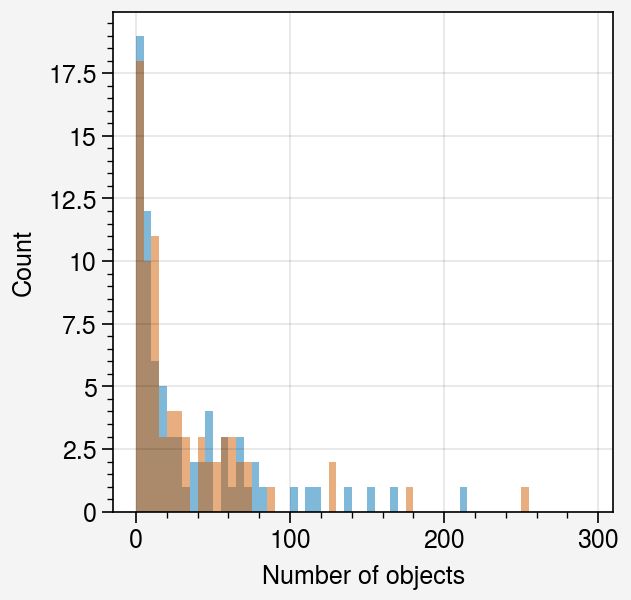

In [10]:
fig, ax = pplt.subplots()
bins = np.arange(0, 300, 5)
_ = ax.hist(case_info['n_aqua'], alpha=0.5, label='Aqua floe count', bins=bins)
_ = ax.hist(case_info['n_terra'], alpha=0.5, label='Terra floe count', bins=bins)
ax.format(ylabel='Count', xlabel='Number of objects')

Step 1. We can only try pairing floes when there are floes in both images

In [11]:
case_info['pair_floes'] = True
case_info.loc[case_info[['n_aqua', 'n_terra']].min(axis=1) == 0, 'pair_floes'] = False
print('Number of candidate cases: ', case_info['pair_floes'].sum(), '/', len(cases))

Number of candidate cases:  68 / 75


Step 2. Look for cases with substantial overlap between floes. 

We default to accepting the matches for cases where the IOU is greater than 50%. Exceptions are handled case by case.

Make sure to test candidates for best match


'005', low confidence - likely reject all
'006', keep most -- check ambiguous cases
'007', keep some. perhaps area similarity?
'008', low confidence, reject all
'009', some motion -- methods for shifting alignment?. Bottom middle floe missing in Aqua.
'010', keep all
'011', keep all. Check split floe - should it be joined?
'012', keep most. Update floe labeling to mark bottom left as landfast (if true)
'013', matches look good
'014', match seems fine
'016', revisit split floe -- is it one really? Enough good floes to drop the poor fit.
'019', drop smallest fit on right

'065', potential reject all - fuzzy image
'067', large drift. Could the optical flow method work? Overlap fails!
'068', large drift. Need some kind of matching or drift computation.
'069', potential large drifts
'093', split floe in Aqua image
'095', keep all
'100', error with floe image saved in the landmask box
'103', wrong floe map!!!
'107', keep all but the lowest match score
'108', keep all
'109', keep all
'110', keep all
'111', test optical flow method!
'112', keep all
'115', test optical flow. One near the top that is mismatched
'116', possible to get one more floe in Aqua. Some mismatched.
'118', keep all




In [14]:
def load_case(case, modis_loc="../data/modis/truecolor/", labeled_loc="../data/validation_images/labeled_floes/"):
    """
    Load the labeled and truecolor images for the case, grab the region props tables, and make a first guess of matches.
    """
    cn, rg, dt, sat, imtype = case.split('-')
    fpath_tc_aqua = modis_loc + '-'.join([cn, rg, '100km', dt]) + '.'.join(['.aqua', 'truecolor', '250m', 'tiff'])
    fpath_tc_terra = modis_loc + '-'.join([cn, rg, '100km', dt]) + '.'.join(['.terra', 'truecolor', '250m', 'tiff'])
    fpath_lb_aqua = labeled_loc + case
    fpath_lb_terra = labeled_loc + case.replace('aqua', 'terra')

    # Convert to RGB -- we don't use the opacity layer
    tc_aqua = rgba2rgb(sk.io.imread(fpath_tc_aqua))
    tc_terra = rgba2rgb(sk.io.imread(fpath_tc_terra))
    
    # Convert float to int for label images
    # Also drop the unused channel layer
    lb_aqua = sk.io.imread(fpath_lb_aqua).astype(int)
    lb_terra = sk.io.imread(fpath_lb_terra).astype(int)
    
    # A couple cases have odd dimensions. Most are 400 by 400 by 3 but some lack the 3rd dim.
    if len(lb_aqua.shape) != 2:
        lb_aqua = lb_aqua[:,:,0]
    if len(lb_terra.shape) != 2:
        lb_terra = lb_terra[:,:,0]
    
    # Load land masks and landfast ice masks
    # Also drop the unused channel layer
    lf_aqua = sk.io.imread(fpath_lb_aqua.replace('labeled_floes', 'binary_landfast').replace('tiff', 'png')).astype(int)
    lf_terra = sk.io.imread(fpath_lb_terra.replace('labeled_floes', 'binary_landfast').replace('tiff', 'png')).astype(int)
    if len(lf_aqua.shape) != 2:
        lf_aqua = lf_aqua[:,:,0]
    if len(lf_terra.shape) != 2:
        lf_terra = lf_terra[:,:,0]

    # Folder naming is different for the landmasks
    lm_aqua = sk.io.imread(fpath_lb_aqua.replace(
                                'labeled_floes/', 'binary_landmask/').replace(
                                        'labeled_floes.tiff', 'landmask.png')).astype(int)    
    lm_terra = sk.io.imread(fpath_lb_terra.replace(
                                'labeled_floes/', 'binary_landmask/').replace(
                                        'labeled_floes.tiff', 'landmask.png')).astype(int)
    if len(lm_aqua.shape) != 2:
        lm_aqua = lm_aqua[:,:,0]
    if len(lm_terra.shape) != 2:
        lm_terra = lm_terra[:,:,0]

    ####### Find regions of overlap ########
    regions_aqua = pd.DataFrame(sk.measure.regionprops_table(
        lb_aqua, properties=['label', 'centroid'])).set_index('label')
    regions_terra = pd.DataFrame(sk.measure.regionprops_table(
        lb_terra, properties=['label', 'centroid'])).set_index('label')

    # Labels where there is some overlap
    aqua_labels = np.ravel(lb_aqua)
    terra_labels = np.ravel(lb_terra)
    labels = np.unique(aqua_labels[(aqua_labels > 0) & (terra_labels > 0)])

    matches = []
    for label in labels:
        idx_aqua = aqua_labels == label
        candidates = np.unique(terra_labels[idx_aqua & (terra_labels > 0)])
        # print(candidates)
        for c in candidates:
            idx_terra = terra_labels == c
            iou = np.sum(idx_terra & idx_aqua) / np.sum(idx_aqua | idx_terra) 
            aqua_area = np.sum(idx_aqua)
            terra_area = np.sum(idx_terra)
            joint_area = np.sum(idx_aqua & idx_terra)
            matches.append([label, c, aqua_area, terra_area, joint_area, iou])
            
    matches = pd.DataFrame(matches, columns=['aqua_label', 'terra_label', 'aqua_area',
                                             'terra_area', 'joint_area', 'iou'])
    if len(matches) > 0:
        for row, data in matches.iterrows():
            r_aqua, c_aqua = regions_aqua.loc[data.aqua_label.astype(int), ['centroid-0', 'centroid-1']]
            r_terra, c_terra = regions_terra.loc[data.terra_label.astype(int), ['centroid-0', 'centroid-1']]
            matches.loc[row, 'r_aqua'] = r_aqua
            matches.loc[row, 'c_aqua'] = c_aqua
            matches.loc[row, 'r_terra'] = r_terra
            matches.loc[row, 'c_terra'] = c_terra
        
        matches['drows'] = matches['r_aqua'] - matches['r_terra']
        matches['dcols'] = matches['c_aqua'] - matches['c_terra']

    fwd_filter = matches.sort_values(['aqua_label', 'iou'])
    fwd_filter = fwd_filter.loc[~fwd_filter['aqua_label'].duplicated(keep='last')]
    bwd_filter = fwd_filter.sort_values(['terra_label', 'iou'])
    bwd_filter = bwd_filter.loc[~bwd_filter['terra_label'].duplicated(keep='last')]
    matches = bwd_filter.copy()

    return regions_aqua, regions_terra, matches, lb_aqua, lb_terra, tc_aqua, tc_terra

In [207]:
idx = 44
cases[idx]

'109-greenland_sea-20220728-aqua-labeled_floes.tiff'

In [ ]:
matches_dict = {}
for case_idx in range(len(cases)):
    regions_aqua, regions_terra, matches, lb_aqua, lb_terra, tc_aqua, tc_terra = load_case(cases[case_idx])
    case_number = cases[case_idx].split('-')[0]
    matches_dict[case_number] = matches

In [235]:
# Ones to keep
# all lower than 250
cases[0]

'001-baffin_bay-20220911-aqua-labeled_floes.tiff'

In [234]:
mdf = matches_dict['155']
mdf.loc[mdf.iou.between(0, 0.5)].sort_values('joint_area')[::-1]

,aqua_label,terra_label,aqua_area,terra_area,joint_area,iou,r_aqua,c_aqua,r_terra,c_terra,drows,dcols
2,24,3,435,502,179,0.236148,170.956322,95.537931,180.320717,88.830677,-9.364395,6.707254
5,29,5,202,219,47,0.125668,183.594059,29.970297,192.872146,29.543379,-9.278087,0.426918
3,27,4,195,181,46,0.139394,181.123077,113.179487,190.204420,108.712707,-9.081343,4.466780
0,22,1,181,180,38,0.117647,154.011050,106.104972,162.455556,101.200000,-8.444506,4.904972
11,44,10,34,62,31,0.476923,207.470588,49.823529,209.016129,50.596774,-1.545541,-0.773245
12,58,13,305,41,28,0.088050,245.150820,54.868852,238.926829,58.073171,6.223990,-3.204318
8,37,6,34,30,14,0.280000,192.000000,69.500000,189.600000,67.600000,2.400000,1.900000


In [227]:
mdf.loc[(mdf['r_aqua'] < 150) & (mdf['iou'].between(0, 0.5))].sort_values('aqua_label').round(2)['aqua_label'].values


array([ 1,  2,  4,  7,  9, 11, 12, 13, 15, 16, 17, 18, 21, 25, 27, 28, 31])

In [196]:
# Format: case number, (all, some, none), empty if all/none, list of aqua labels if label = some
# all: keep every overlap
# all_iou: keep all over 0.5, drop the tentative
# some: keep ones in list
# none: no good matches


filter_dict = {
    '001': ['all', []], 
    '004': ['all', []],
    '005': ['none', []], # Complex case, some potential for matches but its ambiguous
    '006': ['all', []], # Some cases esp. in Aqua image that should be refined
    '007': ['some', [18, 20, 41, 48]], # Additional matches possible with velocity estimates
    '008': ['all', []], # Refine Terra image -- additional large floe possible to discern
    '009': ['some', [1, 5, 8]], # Additional floes possible in Aqua
    '010': ['all', []],
    '011': ['all', []],
    '012': ['all', []], # Fix the Terra image -- we are not including floes that intersect the edge
    '013': ['all', []], # Some in top right overlap due to drift, not matching
    '015': ['all', []], # In bottom right, can link after accounting for drift
    '016': ['some', [3, 6, 9, 12, 13, 18, 27, 32, 42, 94, 118]], # After correcting floe borders, additional matches are possible
    '019': ['some', [5,  7, 13, 14, 18, 19, 24, 25, 31, 32, 33, 48, 65, 67, 70]], # One on the right hand side should be skipped
    '021': ['all', []],
    '022': ['some', [3, 5, 17, 29, 36, 39, 40, 44, 45, 46, 47, 66]],
    '023': ['all', []],
    '029': ['all', []],   # Some to add with larger drift
    '033': ['all', []],
    '043': ['all', []],
    '044': ['all', []],
    '046': ['all', []],
    '047': ['all', []],
    '048': ['all', []],
    '051': ['none', []], # missing floe in Terra image
    '053': ['all', []],
    '056': ['all', []], 
    '062': ['all', []],
    '065': ['none', []], # looks like large drift between images
    '067': ['none', []], # large drift -- potential for linking manually
    '068': ['none', []], # large drift -- potential for manual links
    '071': ['none', []], # large drift -- potential for manual links
    '075': ['all', []],
    '081': ['some', [8]],
    '093': ['all', []], # floe in Aqua image looks like it's incorrectly split into two
    '095': ['all', []],
    '100': ['all', []],
    '107': ['all', []],
    '108': ['all', []],
    '109': ['some', [10, 17]], # Worth checking the three small floes - seems the automatic gets mixed up.
    '110': ['all', []],
    '111': ['all', []], # Additional matches possible with drift correction
    '112': ['some', [4,  5,  7, 10, 12, 14, 16, 17, 20, 22, 26, 27,
                     28, 29, 30, 33, 36, 38, 41, 43, 51, 52, 54, 55, 57, 58, 62]], # dropped 8 with low IOU 
    '115': ['some', [2, 4, 9, 10, 18, 21, 23]],
    '116': ['some', [13, 15, 26]], # potential for additional floes to be identified
    '118': ['all', []],
    '119': ['all', []],
    '121': ['some', [1, 2, 12, 47, 49, 50, 53, 56, 60, 61, 62, 63,
                     64, 65, 67, 69, 75]], # Potential for more matches
    '128': ['all', []],
    '129': ['all', []],
    '138': ['all', []], # Might need to look closer -- seems pretty good though.
    '141': ['all', []],
    '144': ['all', []],
    '148': ['some', [8, 9, 10, 11, 17]], # Some can be fixed with drift correction
    '150': ['none', []], # Looks like the terra images are misaligned, double check
    '152': ['all', []],
    '155': ['some', [29]], # Multiple matcehs possible with drift correction
    '156': ['all_iou', []], # unclear other matches
    '157': ['all', []],
    '158': ['all', []],
    '160': ['all', []],
    '161': ['all', []],
    '164': ['some', [12, 13, 14]], # Drift correction can add matches
    '166': ['none', []], # This one has tons, but drift correction needed
    '171': ['none', []], # Overlap leads to wrong match
    }
# Cases with no potential matches should not be added
# The ones with "none" have some overlapping floes but the implied matches are incorrect

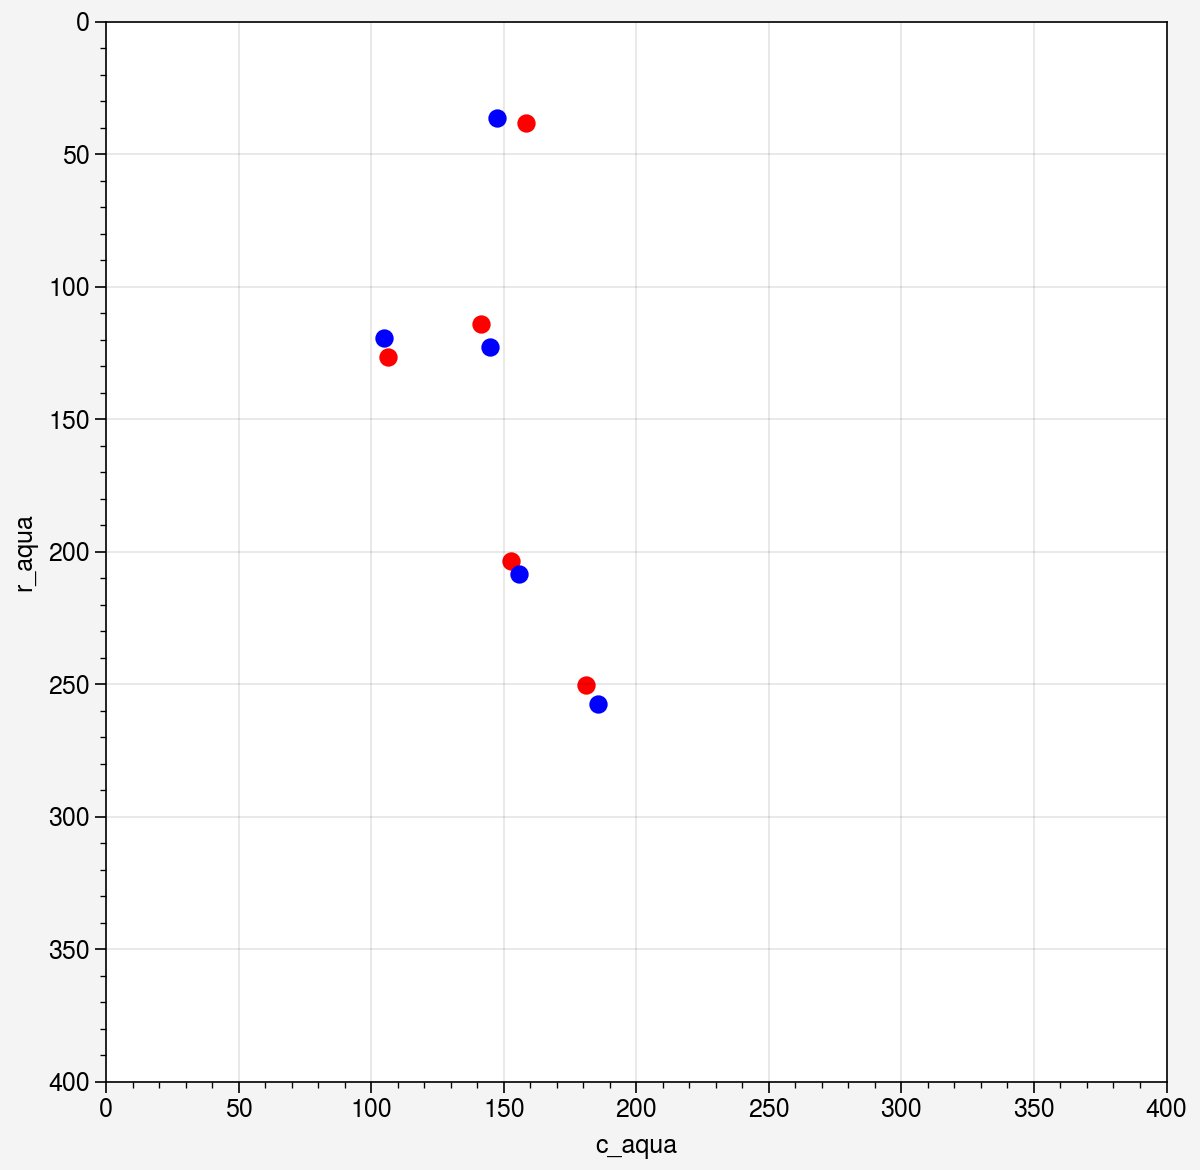

In [222]:
fig, ax = pplt.subplots(width=6)
ax.scatter(mdf.loc[mdf.iou.between(0.0, 0.1)].c_aqua, mdf.loc[mdf.iou.between(0.0, 0.1)].r_aqua, color='r')
ax.scatter(mdf.loc[mdf.iou.between(0.0, 0.1)].c_terra, mdf.loc[mdf.iou.between(0.0, 0.1)].r_terra, color='b')
ax.format(yreverse=True, ylim=(400, 0), xlim=(0, 400))

In [164]:
def adjust_matches(matches_dict, filter_dict, add_dict = {}):
    """
    matches_dict: {case_number, match_df}
    filter_dict: of the flagged matches, which should be kept?
    add_dict: of the unflagged floes, which pairs should be added?
    Returns updated matches dataframe.
    TBD: add column for match type. high_iou, low_iou, added
    TBD: removed -- any auto matches that shouldn't be there?
    """
    updated_matches = {}
    for case in matches_dict:
        init_idx = list(matches_dict[case].loc[matches_dict[case]['iou'] >= 0.5].index)
        if case in filter_dict:
            if filter_dict[case][0] == 'all':
                update
                updated_matches[case]['method'] = 'high_iou'
            elif filter_dict[case][0] == 'some':
                manu_idx = [x for x in matches_dict[case].index if matches_dict[case].loc[x, 'aqua_label'] in filter_dict[case][1]]
                keep_idx = init_idx + manu_idx
                keep_idx.sort()
                updated_matches[case] = matches_dict[case].loc[keep_idx, :].copy()
                updated_matches[case].loc[init_idx, 'method'] = 'high_iou'
                updated_matches[case].loc[manu_idx, 'method'] = 'low_iou_manual'
            else:
                print(case)
                updated_matches[case] = pd.DataFrame(data=np.nan, columns=matches_dict[case].columns, index=[0])
        
    return updated_matches

In [ ]:
# could help to overlay labels!

In [197]:
updated_matches = adjust_matches(matches_dict, filter_dict)

005
051
065
067
068
071


In [198]:
matched_pairs = pd.concat(updated_matches).reset_index().rename({'level_0': 'case_number'}, axis=1).drop('level_1', axis=1)
print(len(matched_pairs))

666


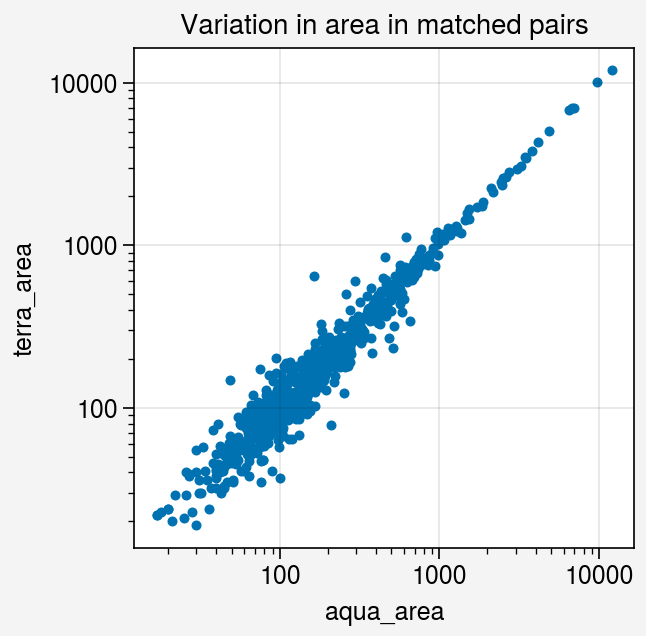

In [199]:
fig, ax = pplt.subplots()
ax.scatter(matched_pairs['aqua_area'], matched_pairs['terra_area'], m='.')
ax.format(yscale='log', xscale='log', title='Variation in area in matched pairs')

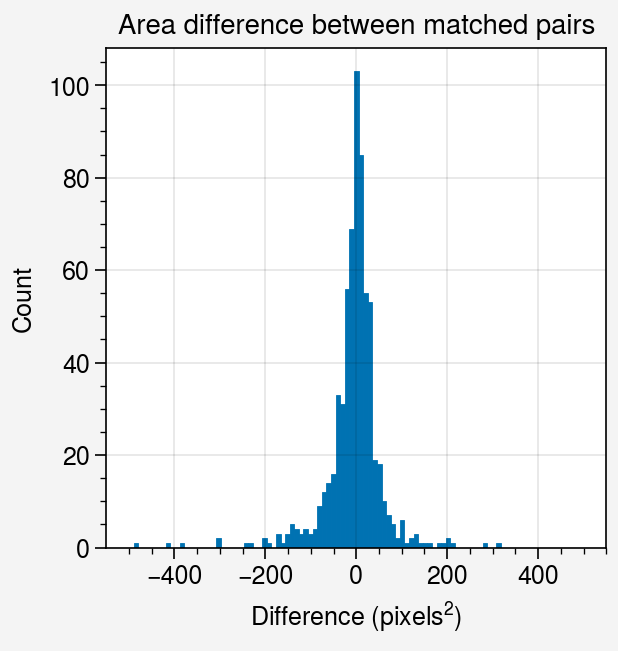

In [200]:
fig, ax = pplt.subplots()
_ = ax.hist(matched_pairs['aqua_area'] - matched_pairs['terra_area'], bins=np.linspace(-500, 500, 100))
ax.format(ylabel='Count', xlabel='Difference (pixels$^2$)', title='Area difference between matched pairs')

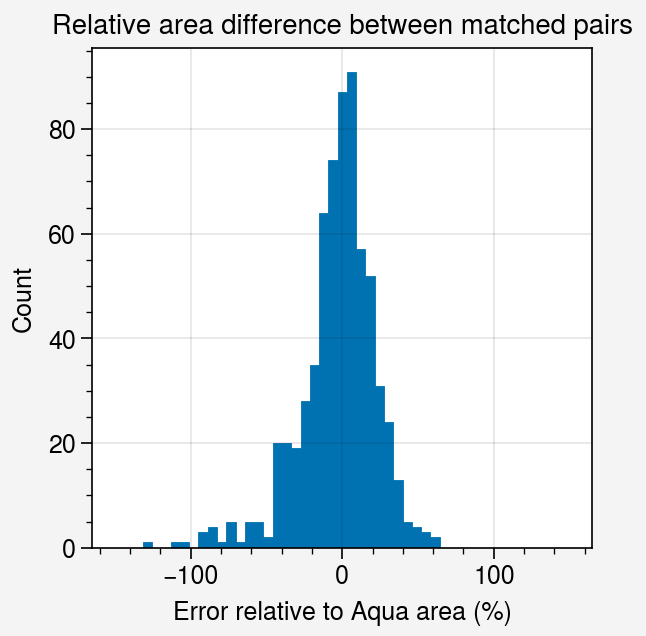

In [201]:
fig, ax = pplt.subplots()
_ = ax.hist(100*(matched_pairs['aqua_area'] - matched_pairs['terra_area'])/matched_pairs['aqua_area'],
            bins=100*np.linspace(-1.5, 1.5, 50))
ax.format(ylabel='Count', xlabel='Error relative to Aqua area (%)', title='Relative area difference between matched pairs')

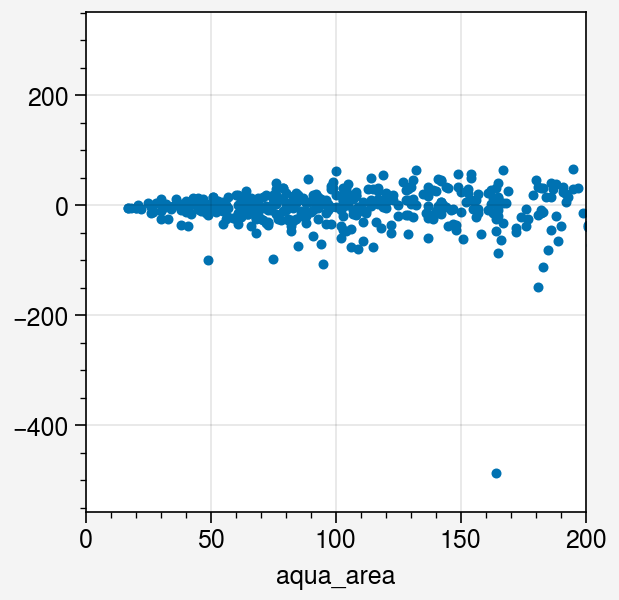

In [202]:
fig, ax = pplt.subplots()
ax.scatter(matched_pairs['aqua_area'],
           (matched_pairs['aqua_area'] - matched_pairs['terra_area']), m='.')
# ax.format(ylim=(-0.5, 0.5), xlim=(0, 800))
ax.format(xlim=(0, 200))
# ax.format(ylabel='Count', xlabel='Difference (pixels$^2$)', title='Relative area difference between matched pairs')

In [141]:

def plot_match_images(regions_aqua, regions_terra, matches, lb_aqua, lb_terra, tc_aqua, tc_terra, case_number):
    """
    Overlay images with candidate matches
    """
    lbmask = lambda im: np.ma.masked_array(im, mask=im==0)
    d = sk.morphology.disk(3)

    fig, axs = pplt.subplots(ncols=3, nrows=2)
    ### Format ###
    # | TC_aqua         | TC_terra         | Floes Alone | 
    # | TC_aqua + masks | TC_terra + masks | Floes Matched |
    
    axs[0, 0].imshow(tc_aqua)
    axs[0, 1].imshow(tc_terra)
    axs[1, 0].imshow(tc_aqua)
    axs[1, 1].imshow(tc_terra)
    
    # Overlay outlines
    axs[1, 0].imshow(lbmask(lb_aqua - sk.morphology.erosion(lb_aqua, footprint=d)), color='r')
    axs[1, 1].imshow(lbmask(lb_terra - sk.morphology.erosion(lb_terra, footprint=d)), color='b')

    # # Overlay masks
    # axs[1, 0].imshow(lbmask(lf_aqua), color='gold')
    # axs[1, 1].imshow(lbmask(lf_terra), color='gold')
    # axs[1, 0].imshow(lbmask(lm_aqua), color='tab:red')
    # axs[1, 1].imshow(lbmask(lm_terra), color='tab:red')

    #### Floe shapes ####
    axs[0, 2].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.25)
    axs[0, 2].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.25)
    axs[1, 2].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.25)
    axs[1, 2].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.25)
    for row, data in matches.iterrows():
        # Overlay outlines of matched objects
        lb_aqua_floe = (lb_aqua == data.aqua_label).astype(int)
        lb_aqua_floe = lb_aqua_floe - sk.morphology.erosion(lb_aqua_floe, footprint=d)
        lb_terra_floe = (lb_terra == data.terra_label).astype(int)
        lb_terra_floe = lb_terra_floe - sk.morphology.erosion(lb_terra_floe, footprint=d)
        axs[1, 2].imshow(lbmask(lb_aqua_floe), color='r')
        axs[1, 2].imshow(lbmask(lb_terra_floe), color='b')
        if data.iou < 0.5:
            axs[1, 2].plot(data.c_aqua, data.r_aqua, c='k', m='+')
            axs[1, 2].text(data.c_aqua, data.r_aqua,
                           int(data.aqua_label), c='r')
# Things for legend:
# landfast ice, landmask, aqua floes, terra floes, matched.
    for c, lw, m, ms, lb in zip(['r', 'b', 'k', 'tab:red', 'gold'], # c
                                [1, 1, 0, 0, 0], # lw
                                ['', '', '+', 's', 's'], # m
                                [0, 0, 5, 5, 5], # ms
                                ['Aqua Floes', 'Terra Floes', 'IOU < 0.5', 'Land', 'Landfast Ice']):
        axs[1, 2].plot([], [], color=c, lw=lw, ms=ms, m=m, label=lb)
    fig.legend(loc='b', ncols=5)
    axs[1, 2].format(yreverse=True, xreverse=False)
    case = ''
    for idx in range(len(cases)):
        if case_number == cases[idx].split('-')[0]:
            case = cases[idx]
    for ax, title in zip(axs, ['Aqua truecolor', 'Terra truecolor', 'Labeled Floes',
                               'Aqua labeled', 'Terra labeled',  'Paired Floes']):
        ax.format(title=title)
        cn, rg, dt, sat, imtype = case.split('-')
    axs.format(yreverse=True, xreverse=False,
               suptitle='Case {cn}: {rg}, {dt}'.format(cn=cn,
               rg=rg.replace('_', ' ').title(),
               dt=pd.to_datetime(dt).strftime('%Y-%m-%d')))
    
    fig.save('../data/validation_images/matching_test_images/' + case_number + '_test_image.png', dpi=300)
    pplt.close(fig)

In [ ]:
matches_dict = {}
for case_idx in range(len(cases)):
    regions_aqua, regions_terra, matches, lb_aqua, lb_terra, tc_aqua, tc_terra = load_case(cases[case_idx])
    case_number = cases[case_idx].split('-')[0]
    # matches_dict[case_number] = matches
    plot_match_images(regions_aqua, regions_terra, matches, lb_aqua, lb_terra, tc_aqua, tc_terra, case_number)

In [71]:
matches.loc[matches.iou > 0.45].sort_values('iou').head(10)


,aqua_label,terra_label,aqua_area,terra_area,joint_area,iou,r_aqua,c_aqua,r_terra,c_terra,drows,dcols
1,3,5,62,52,36,0.461538,17.338710,276.209677,16.615385,277.807692,0.723325,-1.598015
94,118,119,252,123,119,0.464844,368.531746,191.111111,371.894309,189.056911,-3.362563,2.054201
97,123,120,77,65,46,0.479167,372.818182,384.571429,372.830769,382.615385,-0.012587,1.956044
23,33,30,57,62,41,0.525641,114.052632,101.070175,116.193548,101.967742,-2.140917,-0.897566
29,38,36,63,78,49,0.532609,149.269841,357.666667,148.692308,359.115385,0.577534,-1.448718
49,67,62,142,97,86,0.562092,243.866197,117.739437,240.938144,119.020619,2.928053,-1.281182
4,7,8,132,131,95,0.565476,30.522727,365.287879,30.419847,367.251908,0.102880,-1.964030
2,5,7,130,128,95,0.582822,25.561538,112.215385,26.585938,114.179688,-1.024399,-1.964303
12,18,19,79,48,47,0.587500,68.126582,236.594937,67.145833,236.666667,0.980749,-0.071730
41,59,50,83,81,61,0.592233,201.795181,85.927711,203.185185,87.271605,-1.390004,-1.343894


In [71]:
fwd_filter = matches.sort_values(['aqua_label', 'iou'])
fwd_filter = fwd_filter.loc[~fwd_filter['aqua_label'].duplicated(keep='last')]
bwd_filter = fwd_filter.sort_values(['terra_label', 'iou'])
bwd_filter = bwd_filter.loc[~bwd_filter['terra_label'].duplicated(keep='last')]
bwd_filter

,aqua_label,terra_label,aqua_area,terra_area,joint_area,iou,r_aqua,c_aqua,r_terra,c_terra,drows,dcols
0,4,4,242,269,226,0.792982,226.177686,364.632231,225.710037,363.858736,0.467649,0.773495
1,5,5,406,354,193,0.340388,246.332512,128.091133,241.878531,135.675141,4.453981,-7.584008
2,6,6,42,40,29,0.547170,246.857143,77.857143,246.325000,79.125000,0.532143,-1.267857
3,7,7,142,135,60,0.276498,256.077465,94.570423,252.385185,97.022222,3.692280,-2.451800
4,9,9,11976,11899,11129,0.873137,328.515030,114.093520,324.697370,114.706446,3.817661,-0.612926
8,10,10,469,430,264,0.415748,290.170576,62.882729,284.111628,67.400000,6.058948,-4.517271
11,11,11,74,82,20,0.147059,300.175676,37.959459,295.902439,43.036585,4.273237,-5.077126
15,13,13,80,89,27,0.190141,311.487500,39.350000,307.033708,42.426966,4.453792,-3.076966


In [63]:
matches.sort_values(['aqua_label', 'iou'])

,aqua_label,terra_label,aqua_area,terra_area,joint_area,iou,r_aqua,c_aqua,r_terra,c_terra,drows,dcols
0,4,4,242,269,226,0.792982,226.177686,364.632231,225.710037,363.858736,0.467649,0.773495
1,5,5,406,354,193,0.340388,246.332512,128.091133,241.878531,135.675141,4.453981,-7.584008
2,6,6,42,40,29,0.547170,246.857143,77.857143,246.325000,79.125000,0.532143,-1.267857
3,7,7,142,135,60,0.276498,256.077465,94.570423,252.385185,97.022222,3.692280,-2.451800
5,9,14,11976,337,3,0.000244,328.515030,114.093520,354.789318,153.824926,-26.274287,-39.731405
6,9,15,11976,2331,14,0.000980,328.515030,114.093520,384.206778,34.417417,-55.691748,79.676103
7,9,16,11976,852,53,0.004149,328.515030,114.093520,380.557512,107.461268,-52.042482,6.632253
4,9,9,11976,11899,11129,0.873137,328.515030,114.093520,324.697370,114.706446,3.817661,-0.612926
10,10,12,469,43,14,0.028112,290.170576,62.882729,300.116279,58.534884,-9.945703,4.347845
9,10,11,469,82,31,0.059615,290.170576,62.882729,295.902439,43.036585,-5.731863,19.846144


In [49]:
np.unique(terra_labels[(aqua_labels > 0) & (terra_labels > 0)])

array([1])

In [50]:
terra_labels.max()

1

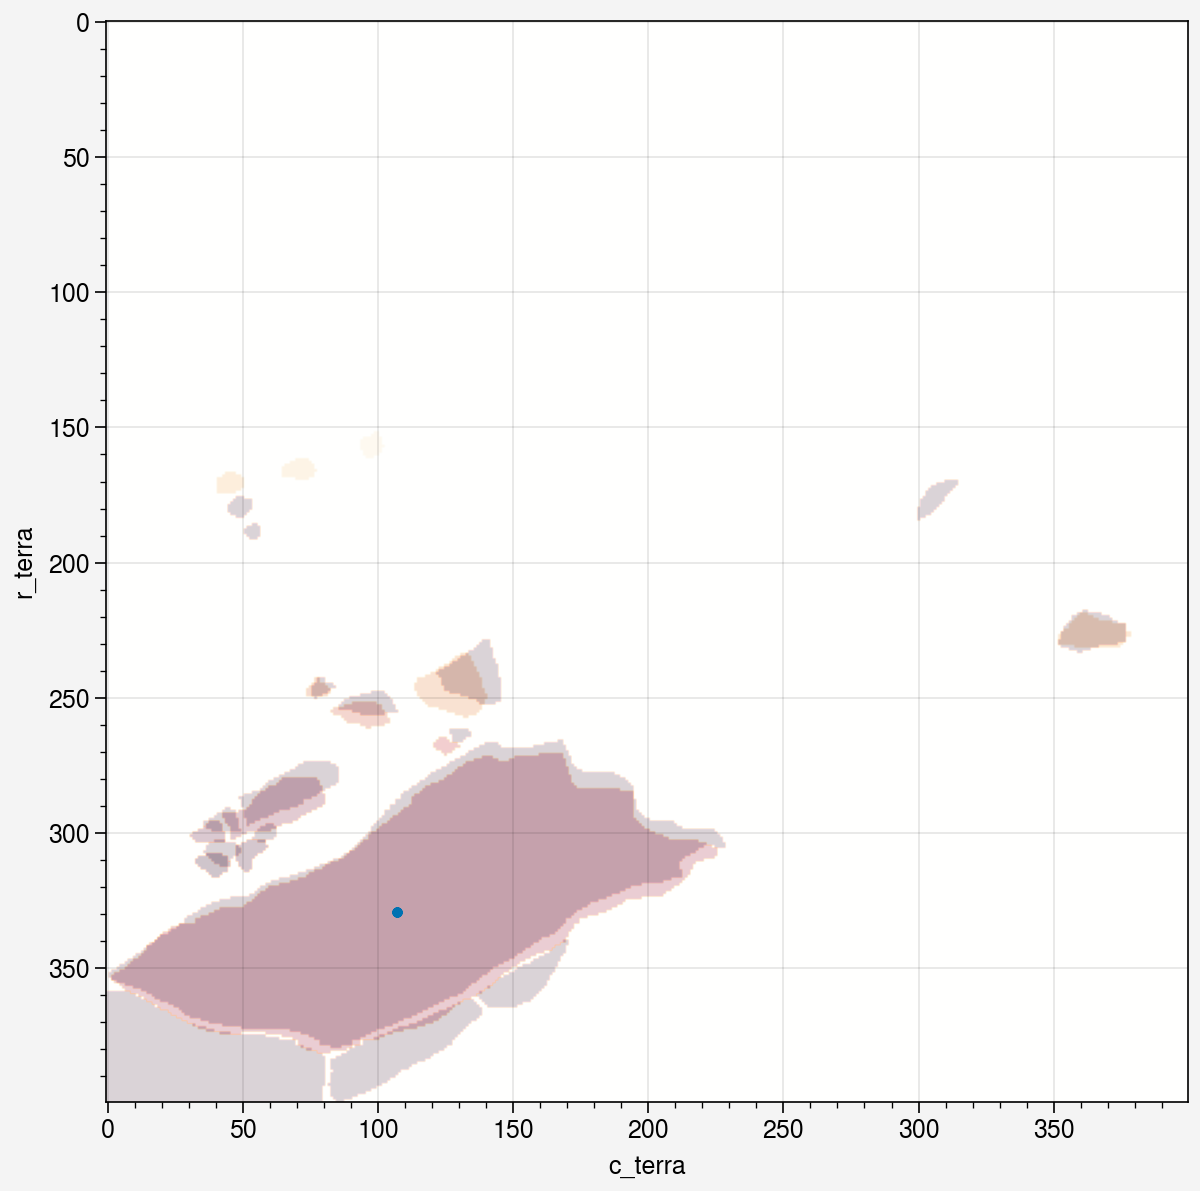

In [44]:
fig, ax = pplt.subplots(width=6)
ax.imshow(lb_terra, alpha=0.25)
ax.imshow(lb_aqua, alpha=0.25)
ax.scatter(matches.c_terra, matches.r_terra, m='.')

In [ ]:
    break
    
    # axs[0, 2].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
    # axs[0, 2].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
    # axs[0, 2].format(title='Overlay of Aqua and Terra labeled floes')
    # for c, lw, ms, lb in zip(['r', 'b'],
    #                          [0, 0], [10, 10],
    #                          ['Aqua', 'Terra']):
    #     axs[0, 2].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
    # axs[0, 2].legend(loc='ur', ncols=1)
    
    
    axs[0, 2].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.25)
    axs[0, 2].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.25)
    # axs[0, 2].imshow(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)),
    #                  vmin=0, vmax=1, c='k', alpha=1)
    axs[1, 2].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.25)
    axs[1, 2].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.25)
    for c, lw, ms, lb in zip(['r', 'b', 'k'],
                             [0, 0, 1], [10, 10, 0], ['Aqua', 'Terra', 'Terra Warped']):
        axs[0, 2].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
    axs[0, 2].legend(loc='r', ncols=1)
    if len(matches) > 0:
        idx = matches['iou'] > 0.5
        axs[1, 2].scatter(matches.loc[idx, 'c_aqua'], matches.loc[idx, 'r_aqua'], marker='.', color='r', label='Centroid Aqua')
        axs[1, 2].scatter(matches.loc[idx, 'c_terra'], matches.loc[idx, 'r_terra'], marker='.', color='b', label='Centroid Terra')

        for row, data in matches.iterrows():
            if data['iou'] > 0.5:
                axs[1, 2].plot(data[['c_aqua', 'c_terra']].values,
                           data[['r_aqua', 'r_terra']].values, lw=1, color='k')
        
    for c, lw, ms, lb in zip(['r', 'b', 'k'],
                             [0, 0, 1], [10, 10, 0], ['Aqua', 'Terra', 'Matched']):
        axs[1, 2].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
    axs[1, 2].legend(loc='r', ncols=1)
    axs[1, 2].format(yreverse=True, xreverse=False)
    
    for ax, title in zip(axs, ['Aqua truecolor', 'Terra truecolor', 'Floe masks + Warp',
                               'Aqua Floes', 'Paired Floes']):
        ax.format(title=title)
    axs.format(yreverse=True, xreverse=False)
    fig.save('../data/validation_images/matching_test_images/' + case.split('-')[0] + '_test_image.png', dpi=300)
    pplt.close(fig)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 124)

In [125]:
# setting the optical flow stuff aside        
        # # Convert to grayscale for the optical flow algorithms
        # # (They're finding a best guess velocity field assuming constant brightness)
        # nr, nc = lb_aqua.shape
        # row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')

        # im1 = sk.color.rgb2gray(tc_aqua)
        # im2 = sk.color.rgb2gray(tc_terra)
        # v, u = sk.registration.optical_flow_ilk(reference_image=im1,
        #                                       moving_image=im2,
        #                                       radius=7,
        #                                       num_warp=10,
        #                                       gaussian=False, prefilter=False)
        # # v0, u0 = sk.registration.optical_flow_tvl1(im1, im2)
    
    
        # lb_warp = sk.transform.warp(lb_terra,
        #                             np.array([row_coords + v, col_coords + u]),
        #                             order=0, mode='constant', cval=0)

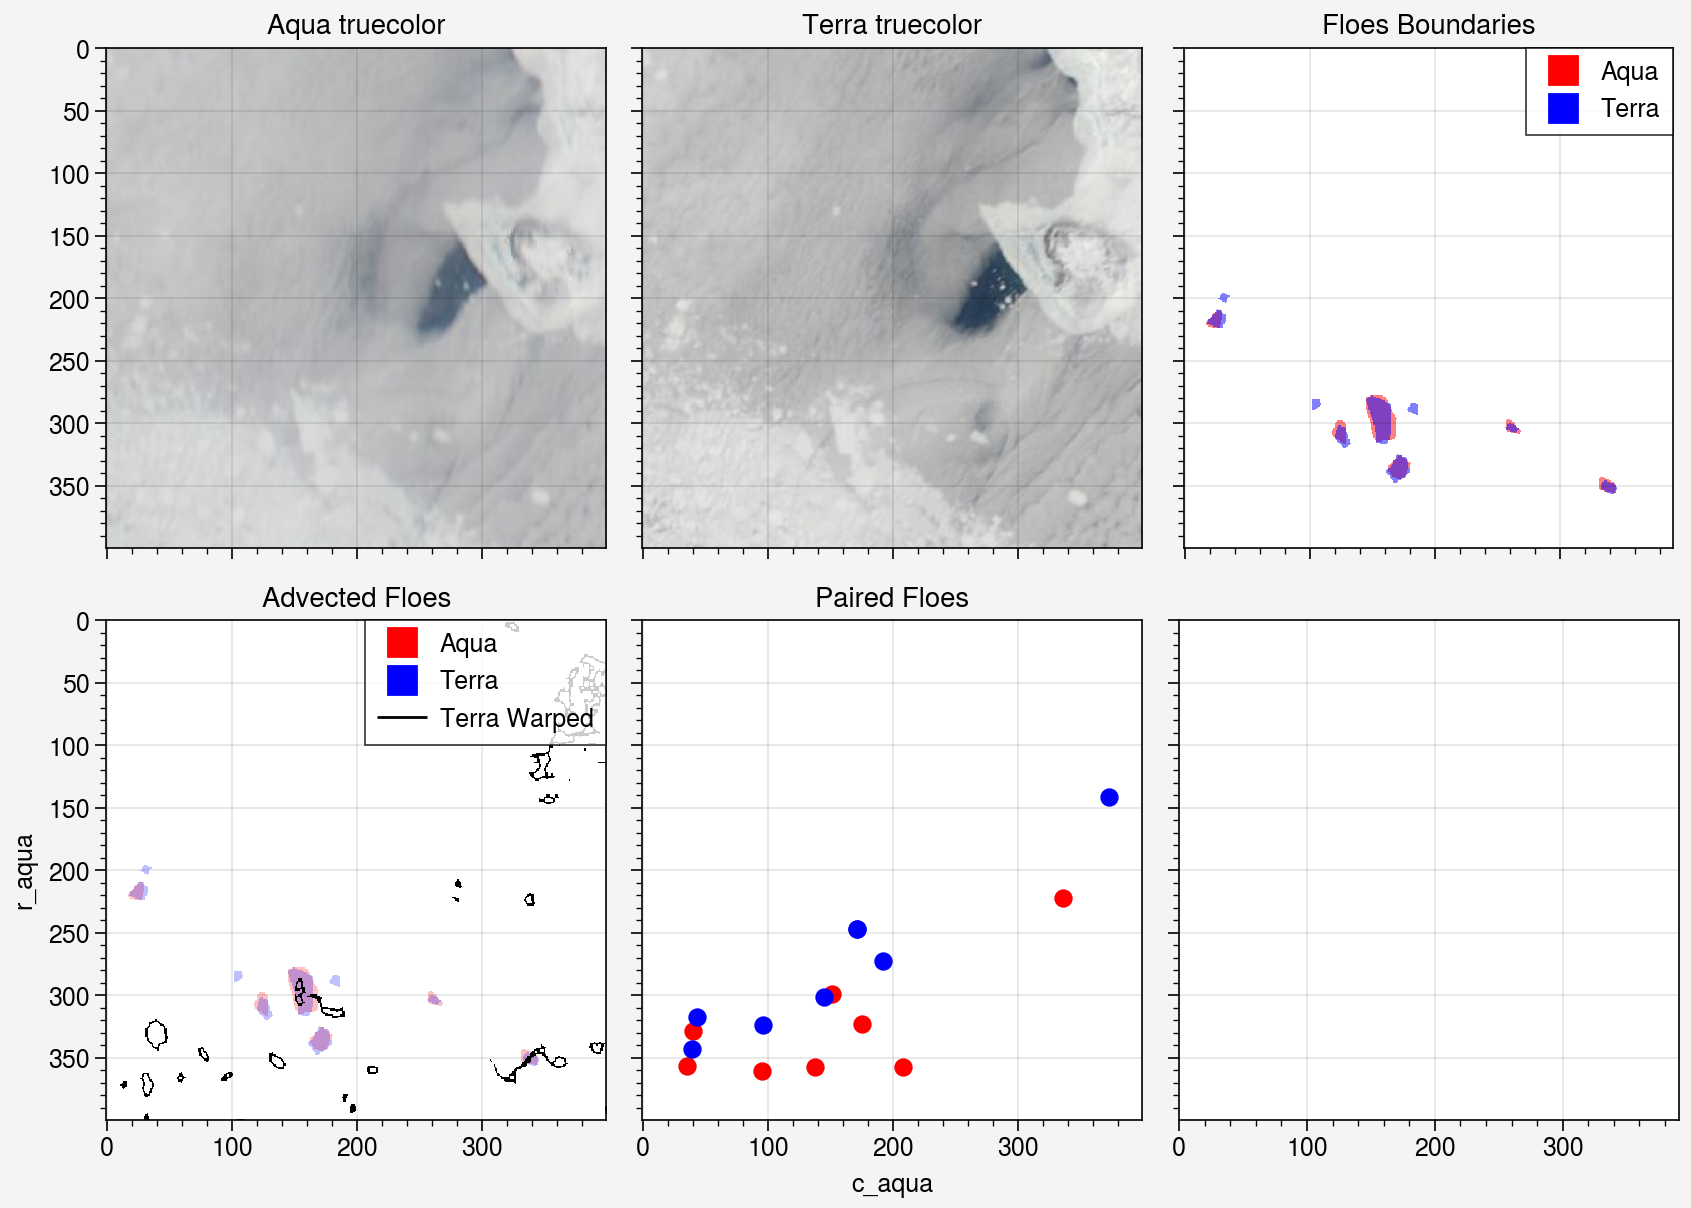

In [44]:
lbmask = lambda im: np.ma.masked_array(im, mask=im==0)

fig, axs = pplt.subplots(ncols=3, nrows=2)
axs[0, 0].imshow(tc_aqua)
axs[0, 1].imshow(tc_terra)
# axs[0, 1].imshow(lbmask(lb_aqua), cmap='spectral')
# axs[1, 1].imshow(lbmask(lb_terra), cmap='spectral')

axs[0, 2].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
axs[0, 2].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
axs[0, 2].format(title='Overlay of Aqua and Terra labeled floes')
for c, lw, ms, lb in zip(['r', 'b'],
                         [0, 0], [10, 10],
                         ['Aqua', 'Terra']):
    axs[0, 2].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
axs[0, 2].legend(loc='ur', ncols=1)


d = sk.morphology.disk(3)

axs[1, 0].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.25)
axs[1, 0].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.25)
axs[1, 0].imshow(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), vmin=0, vmax=1, c='k', alpha=1)
for c, lw, ms, lb in zip(['r', 'b', 'k'],
                         [0, 0, 1], [10, 10, 0], ['Aqua', 'Terra', 'Terra Warped']):
    axs[1, 0].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
axs[1, 0].legend(loc='ur', ncols=1)
# ax.format(yreverse=True, title='Result of Optical Flow')
# fig.save('../figures/optical_flow_example_166.png', dpi=300)

axs[1, 1].scatter(matches['c_aqua'], matches['r_aqua'], color='r')
axs[1, 1].scatter(matches['c_terra'], matches['r_terra'], color='b')

for ax, title in zip(axs, ['Aqua truecolor', 'Terra truecolor', 'Floes Boundaries',
                           'Advected Floes', 'Paired Floes']):
    ax.format(title=title)

# ax.format(suptitle="Example case: Laptev Sea, Case 166",
#           leftlabels=['Truecolor', 'Manual labels'], toplabels=['Aqua', 'Terra'])
# fig.save("../figures/optical_flow_example_4x4_166.png", dpi=300)

In [128]:
matches['d'] = np.sqrt(matches['drows']**2 + matches['dcols']**2)

In [129]:
matches

,aqua_label,terra_label,iou,r_aqua,c_aqua,r_terra,c_terra,drows,dcols,d
0,4,1,0.099744,63.937984,145.286822,45.030096,192.281806,NaN,NaN,NaN
1,9,2,0.606949,89.445748,156.060117,91.273183,156.160401,NaN,NaN,NaN
2,10,5,0.054366,90.625850,287.836735,110.569980,292.277890,NaN,NaN,NaN
3,13,2,0.057282,96.780069,128.092784,91.273183,156.160401,NaN,NaN,NaN
4,14,2,0.082833,98.365385,185.778846,91.273183,156.160401,NaN,NaN,NaN
5,17,6,0.008338,150.757303,256.906180,125.974194,274.554839,NaN,NaN,NaN
6,17,7,0.062020,150.757303,256.906180,168.272374,277.520752,NaN,NaN,NaN
7,18,8,0.104235,194.145161,205.790323,198.493023,221.986047,-4.347862,-16.195724,16.769179


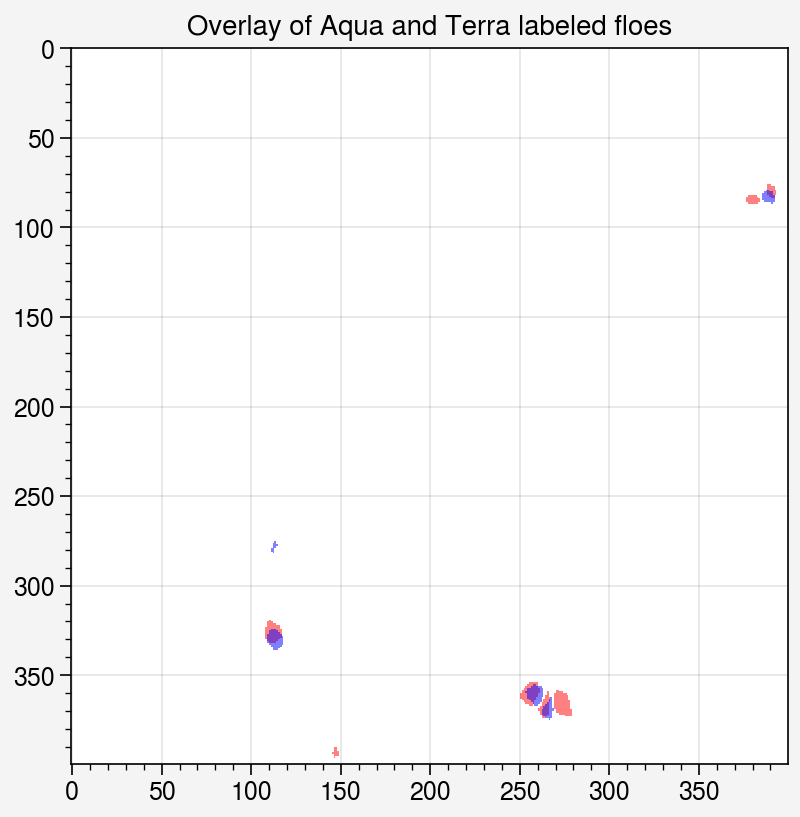

In [154]:
import proplot as pplt
import numpy as np
fig, ax = pplt.subplots(width=4)
ax.imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
ax.imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
ax.format(title='Overlay of Aqua and Terra labeled floes')

Overlapping the images shows that the floes move enough that we can't just look for an overlap, and we also know that there's differences in the velocity across the image. We can enhance contrast in the original image by using the floes as a mask.

In [5]:
im1 = sk.color.rgb2gray(tc_aqua)
im2 = sk.color.rgb2gray(tc_terra)
v, u = sk.registration.optical_flow_ilk(reference_image=im1,
                                      moving_image=im2,
                                      radius=7,
                                      num_warp=10,
                                      gaussian=False, prefilter=False)
v0, u0 = sk.registration.optical_flow_tvl1(im1, im2)

In [6]:
nr, nc = im1.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
im2_warp = sk.transform.warp(im2, np.array([row_coords + v, col_coords + u]), order=0, mode='constant', cval=0)

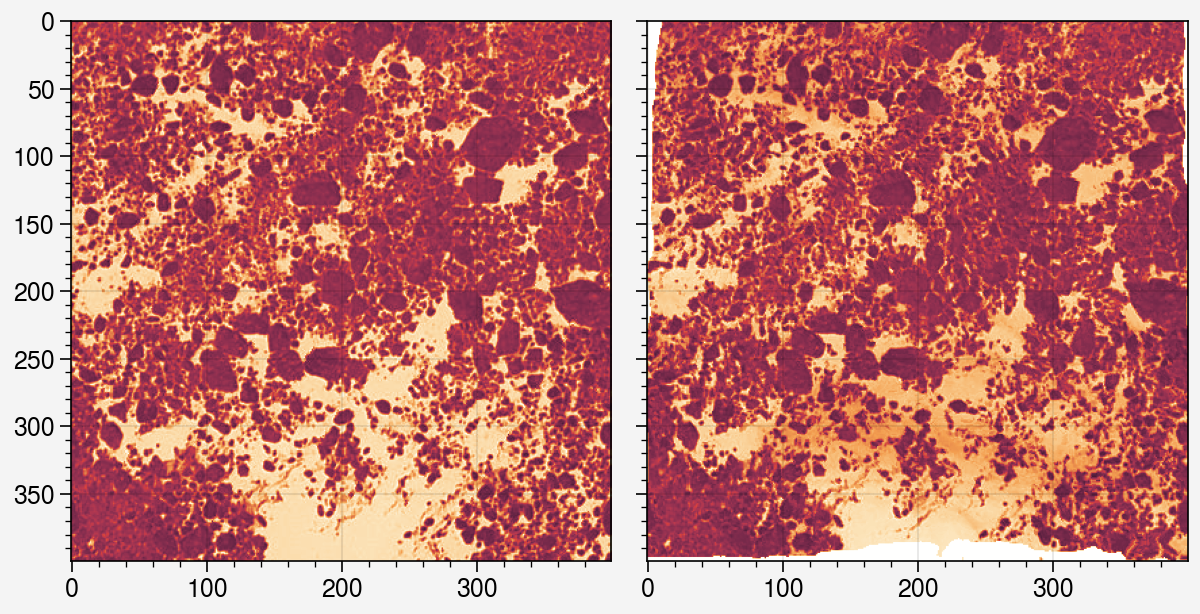

In [7]:
fig, ax = pplt.subplots(width=6, ncols=2)
ax[0].imshow(im1)
ax[1].imshow(im2_warp)

In [9]:
lb_terra_ = sk.measure.label(lb_terra)
lb_warp = sk.transform.warp(lb_terra_[:,:], np.array([row_coords + v, col_coords + u]), order=0, mode='constant', cval=0)

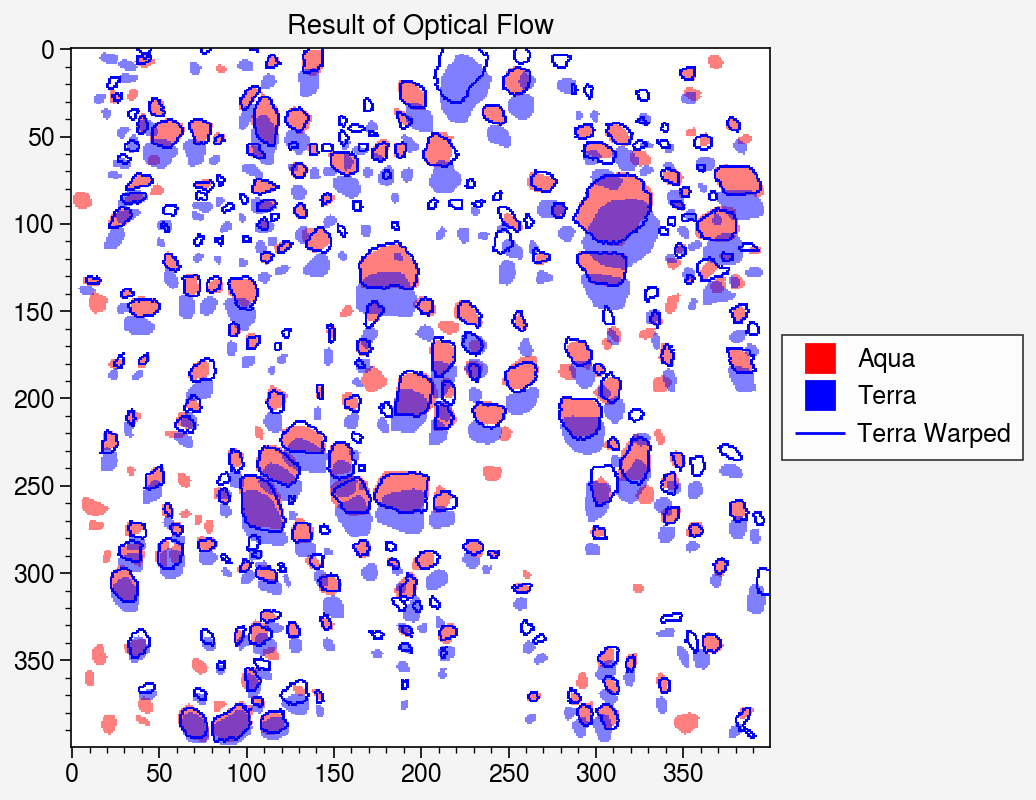

In [26]:
import proplot as pplt
import numpy as np
d = sk.morphology.disk(1)
fig, ax = pplt.subplots(height=4)
ax.pcolormesh(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
ax.pcolormesh(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
ax.pcolormesh(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), c='b', alpha=1)
for c, lw, ms, lb in zip(['r', 'b', 'b'], [0, 0, 1], [10, 10, 0], ['Aqua', 'Terra', 'Terra Warped']):
    ax.plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
ax.legend(loc='r', ncols=1)
ax.format(yreverse=True, title='Result of Optical Flow')
fig.save('../figures/optical_flow_example_166.png', dpi=300)

# Findings
For this "easy" image (166), and a harder image (160) optical flow works pretty well! Here's the method:
1. Apply optical flow to the true color images to find the best transform
2. Apply the transform to the labeled image using nearest neighbors and fill edges with 0
3. Pair the labeled image and the warped labeled image using the relevant set method
4. Keep only objects with a single member of the relevant set

Potentially, find the optimal rotation prior to describing the variance in shape parameters.

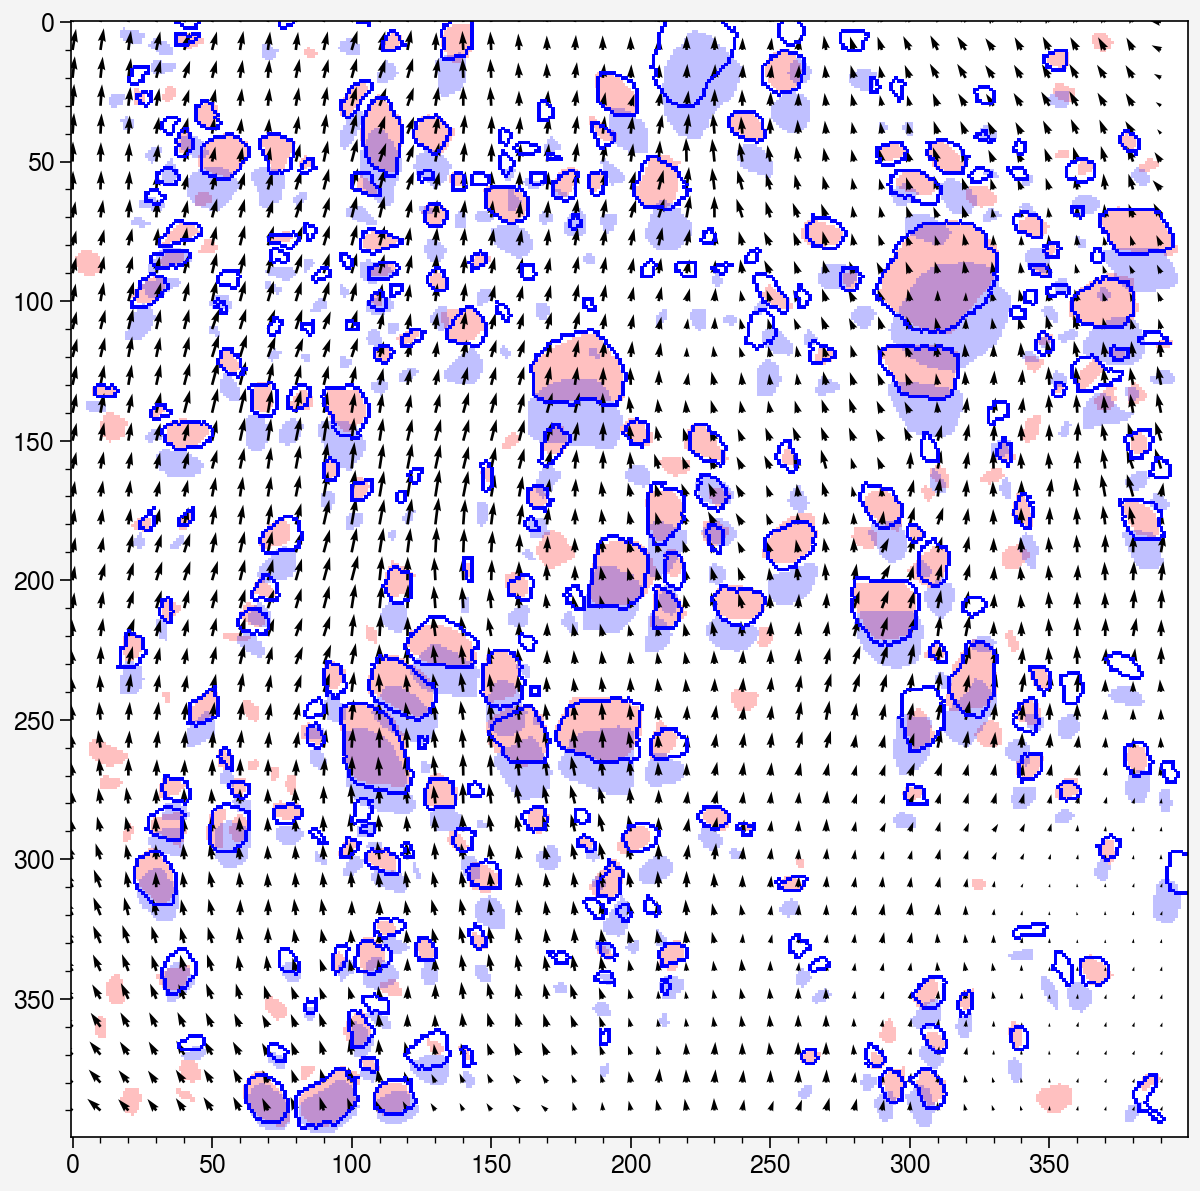

In [39]:
fig, ax = pplt.subplots(width=6)
# Need to figure out the right way to align Quiver with the image orientation convention. Some axis has to get flipped.
ax.quiver(row_coords[::10, ::10], col_coords[::10, ::10], u[::10, ::-10], v[::10, ::-10])
# ax.quiver(row_coords[::10, ::10], col_coords[::10, ::10], u0[::10, ::10], v0[::10, ::10], color='green')
ax.imshow(lbmask(lb_aqua[:,:]), vmin=0, vmax=1, color='r', alpha=0.25)
ax.imshow(lbmask(lb_terra[:,:]), vmin=0, vmax=1, color='b', alpha=0.25)
ax.pcolormesh(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), c='b', alpha=1)
ax.format(yreverse=True)

In [40]:
# simple script: save the labeled images
import skimage as sk
import os
binary_dataloc = "../data/validation_images/binary_floes/"
files = [f for f in os.listdir(binary_dataloc) if 'png' in f]
for file in files:
    im = sk.io.imread(binary_dataloc + file)
    labeled_dataloc = binary_dataloc.replace("binary", "labeled")
    labeled_im = sk.measure.label(im).astype(float)
    sk.io.imsave(labeled_dataloc + file.replace("binary", "labeled").replace("png", "tiff"), 
             labeled_im, check_contrast=False)

In [65]:
comp = sk.io.imread(labeled_dataloc + files[0].replace("binary", "labeled").replace("png", "tiff"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


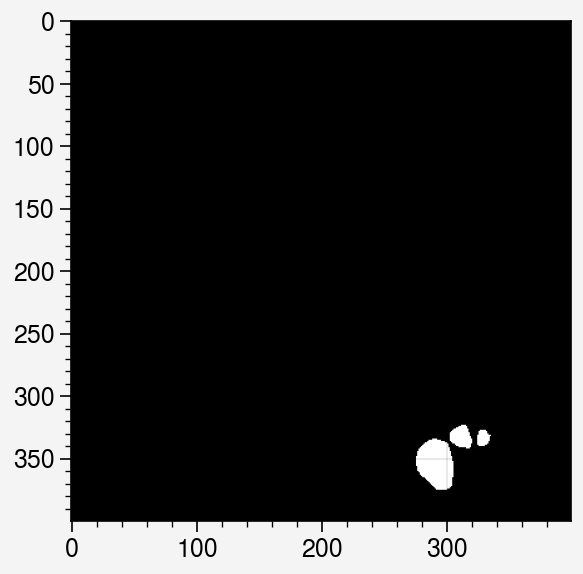

In [67]:
fig, ax = pplt.subplots()
ax.imshow(comp)

In [73]:
comp.astype(int) == test_im

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,